In [1]:
import pickle

with open('elvish-names.pickle', "rb") as file:
    names = pickle.load(file)

In [2]:
import torchtext

assert torchtext.__version__ == '0.8.1'

## Dataset

**Processing pipeline:**

chars (tokens) $\to$ indices $\to$ embeddings $\to$ RNN output, hidden $\to$ next char logits

In [3]:
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab
from collections import Counter


class NamesDataset(Dataset):
    def __init__(self, names):
        self.names = names
        self.specials = ['<pad>', '<bos>', '<eos>']
        counter = Counter(''.join(names))
        self.vocab = Vocab(counter, specials=self.specials)
        self.pad_index = self.vocab['<pad>']
        self.bos_index = self.vocab['<bos>']
        self.eos_index = self.vocab['<eos>']
        self.max_len = max(len(name) for name in names) + 2

    def __len__(self):
        return len(self.names)

    def str_to_idx(self, chars):
        return [self.vocab[char] for char in chars]
    
    def idx_to_str(self, idx):
        return [self.vocab.itos[index] for index in idx]
    
    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)
        
    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return ''.join(char for char in chars if char not in self.specials)

    def __getitem__(self, item):
        encoded = self.encode(self.names[item])
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.int64)
        padded[:len(encoded)] = torch.tensor(encoded)
        return padded, len(encoded)

In [4]:
dataset = NamesDataset(names)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
for names, _ in dataloader:
    break

# 0 - <pad>
# 1 - <bos>
# 2 - <eos>
names[:4]

tensor([[ 1, 23, 13,  4, 15,  6,  4,  2,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 24,  9,  3, 16, 14,  4,  8, 10,  9,  6,  2,  0,  0,  0,  0],
        [ 1,  6, 15,  3,  7, 11, 13,  4,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 13,  7, 11,  9,  3,  6,  5,  2,  0,  0,  0,  0,  0,  0,  0]])

## Generator model

Embedding + RNN + Linear head

In [6]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

class Generator(nn.Module):
    def __init__(self, dataset, embed_dim=32, hidden_dim=32, max_len=None):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=len(dataset.vocab), embedding_dim=embed_dim)
        self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(dataset.vocab))
        self.dataset = dataset
        self.max_len = dataset.max_len if max_len is None else max_len
    
    def forward(self, tokens, lengths):
        '''
        B - batch size
        L - sequence length
        E - embedding dim
        H - hidden dim
        V - vocab size
        '''
        # tokens: (B, L)
        embeds = self.embedding(tokens)
        # embeds: (B, L, E) in padded form
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed_embeds)
        # output: (B, L, H), hidden: (B, H) in packed form
        outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        logits = self.linear(outputs)
        # logits: (B, L, V)
        return logits
    
    @torch.no_grad()
    def inference(self, prefix=''):
        # encode prefix
        tokens = self.dataset.encode(prefix)[:-1]
        tokens = torch.tensor(tokens).unsqueeze(0)
        
        # generate hidden for prefix
        embeds = self.embedding(tokens)
        output, hidden = self.rnn(embeds)
        logits = self.linear(output)
        # sample new token from logits
        new_tokens = Categorical(logits=logits[:, -1:]).sample()
        tokens = torch.cat([tokens, new_tokens], dim=1)
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < self.max_len:
            if new_tokens.item() == self.dataset.eos_index:
                break

            # process newly obtained token
            embeds = self.embedding(new_tokens)
            output, hidden = self.rnn(embeds, hidden)
            logits = self.linear(output)
            # sample the next token from logits
            new_tokens = Categorical(logits=logits[:, -1:]).sample()
            tokens = torch.cat([tokens, new_tokens], dim=1)
        
        # decode result to a string
        return self.dataset.decode(tokens.squeeze())

In [7]:
model = Generator(dataset, embed_dim=32, hidden_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.pad_index)

In [8]:
# inference for untrained model - trash
[model.inference('') for _ in range(10)]

['xaisfxpicedq',
 'vshvcpsisjiqlz',
 'cpgbcovoasgqsmi',
 '',
 'ynxdihwsrkddvx',
 'idbxpsmntwaclo',
 'dzjo',
 'ikfqafrsgi',
 'ggzhkreufkaxxx',
 'armhrqnsxdeyowp']

## Training

In [9]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.show()

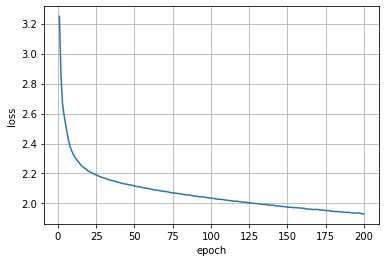

In [10]:
losses = []
num_epochs = 200

for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    model.train()
    for tokens, lengths in dataloader:
        optimizer.zero_grad()
        tokens = tokens[:, :lengths.max()]
        logits = model(tokens[:, :-1], lengths - 1)
        # logits: (B, L, V), tokens: (B, L) - need to transpose logits
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * tokens.shape[0]
    
    losses += [running_loss / len(dataset)]
    
    if epoch % 10 == 0:
        plot_losses(losses)

In [11]:
# unconditional generation
[model.inference('') for _ in range(10)]

['sanaryni',
 'alarus',
 'drindrael',
 'auvelana',
 'jhasuajhil',
 'paerels',
 'klaundorn',
 'elasiiar',
 'xanave',
 'enlaunee']

In [12]:
# conditional generation from prefix
[model.inference('an') for _ in range(10)]

['antaus',
 'anamytar',
 'angauthore',
 'annallafar',
 'anmauir',
 'aniare',
 'anaana',
 'anmynmen',
 'anathleun',
 'anareth']